<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_3_Classical_Time_Series_%26_Machine_Learning_Models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Step 1: Install and Import Necessary Libraries ---
# Uninstall and reinstall numpy and pmdarima to resolve potential compatibility issues
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install pmdarima




Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 100.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.1 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pmdarima as pm
from math import sqrt

# Metrics and CV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Classical Models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

In [2]:
# --- Step 2: Helper Functions & Data Prep ---

# Helper functions for metrics
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0 if mask.sum() > 0 else np.nan

# Helper functions for classical models
def infer_seasonal_period(y: pd.Series):
    if y.index.freqstr:
        freq = y.index.freqstr.upper()
        if freq in ("D", "B"): return 7
        if "W" in freq: return 52
        if "M" in freq: return 12
    return 7 # Default

def fit_predict_arima(y_train, fh, seasonal_period):
    model = pm.auto_arima(y_train, seasonal=True, m=seasonal_period, suppress_warnings=True, error_action='ignore', stepwise=True)
    return model.predict(n_periods=fh)

def fit_predict_ets(y_train, fh, seasonal_period):
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=seasonal_period, initialization_method='estimated').fit()
    return model.forecast(fh)

def fit_predict_prophet(y_train, fh):
    train_df = y_train.reset_index().rename(columns={'Date': 'ds', 'calls': 'y'})
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(y_test), freq='D')
    forecast = model.predict(future).tail(len(y_test))
    return forecast['yhat'].values

# Load and prepare data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls' # Corrected column name

# Feature Engineering for ML models
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)
df['Rolling_Mean_7'] = df[target].rolling(window=7).mean()
df['Rolling_Std_7'] = df[target].rolling(window=7).std()
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)
df = df.dropna()

features = [col for col in df.columns if col != target and df[col].dtype in ['float64', 'int64', 'bool', 'uint8']]
X = df[features]
y = df[target]

print("Data and functions are ready.")

Data and functions are ready.


In [3]:
# --- Step 2: Helper Functions & Data Prep ---

# Helper functions for metrics
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0 if mask.sum() > 0 else np.nan

# Helper functions for classical models
def infer_seasonal_period(y: pd.Series):
    if y.index.freqstr:
        freq = y.index.freqstr.upper()
        if freq in ("D", "B"): return 7
        if "W" in freq: return 52
        if "M" in freq: return 12
    return 7 # Default

def fit_predict_arima(y_train, fh, seasonal_period):
    model = pm.auto_arima(y_train, seasonal=True, m=seasonal_period, suppress_warnings=True, error_action='ignore', stepwise=True)
    return model.predict(n_periods=fh)

def fit_predict_ets(y_train, fh, seasonal_period):
    model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=seasonal_period, initialization_method='estimated').fit()
    return model.forecast(fh)

def fit_predict_prophet(y_train, fh):
    train_df = y_train.reset_index().rename(columns={'Date': 'ds', 'calls': 'y'})
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=fh, freq='D')
    forecast = model.predict(future).tail(fh)
    return forecast['yhat'].values

# Load and prepare data
df = pd.read_csv('enhanced_eda_data.csv', index_col='Date', parse_dates=True)
target = 'calls' # Corrected column name

# Feature Engineering for ML models
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)
df['Rolling_Mean_7'] = df[target].rolling(window=7).mean()
df['Rolling_Std_7'] = df[target].rolling(window=7).std()
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)
df = df.dropna()

features = [col for col in df.columns if col != target and df[col].dtype in ['float64', 'int64', 'bool', 'uint8']]
X = df[features]
y = df[target]

print("Data and functions are ready.")

Data and functions are ready.


In [4]:
# --- Step 3: Run Cross-Validation and Produce Leaderboard ---

# Helper function for MASE
# def mase(y_true, y_pred, y_train):
#     numerator = np.mean(np.abs(y_true - y_pred))
#     denominator = np.mean(np.abs(y_train[1:] - y_train[:-1]))
#     return numerator / denominator if denominator != 0 else np.nan

# Enhanced: Function to calculate metrics + MASE (scaled to Seasonal Naive)
from sklearn.metrics import mean_absolute_percentage_error # Import MAPE

def calculate_metrics(y_true, y_pred, naive_seasonal_mae=858):  # From Step 2 baseline
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mase = mae / naive_seasonal_mae  # Relative to seasonal naive benchmark
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'MASE': mase}


tscv = TimeSeriesSplit(n_splits=5)
all_metrics = {}
seasonal_period = infer_seasonal_period(y)

# --- PART 1: Classical Models CV ---
print("--- Running Classical Models (ARIMA, ETS, Prophet) ---")
classical_models = {
    'ARIMA': fit_predict_arima,
    'ETS': fit_predict_ets,
    'Prophet': fit_predict_prophet
}

for name, func in classical_models.items():
    maes = []
    rmses = []
    mapes = []
    mases = []
    print(f"Cross-validating {name}...")
    for train_idx, test_idx in tscv.split(y):
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        fh = len(y_test)

        # ETS and ARIMA need the seasonal period passed in
        if name in ['ETS', 'ARIMA']:
            forecast = func(y_train, fh, seasonal_period=seasonal_period)
        else: # Prophet does not
            forecast = func(y_train, fh)

        metrics = calculate_metrics(y_test.values, forecast) # Convert y_test to numpy array
        maes.append(metrics['MAE'])
        rmses.append(metrics['RMSE'])
        mapes.append(metrics['MAPE'])
        mases.append(metrics['MASE'])

    all_metrics[name] = {'MAE': np.mean(maes), 'RMSE': np.mean(rmses), 'MAPE': np.mean(mapes), 'MASE': np.mean(mases)}
    print(f"{name} Average CV MAE: {np.mean(maes):.2f}")

# --- PART 2: Machine Learning Models CV ---
print("\n--- Running Machine Learning Models (XGBoost, RandomForest, etc.) ---")
ml_models = {
    'XGBoost': XGBRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}
param_grids = {
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]}
}

for name, model in ml_models.items():
    maes = []
    rmses = []
    mapes = []
    mases = []
    print(f"\nRunning GridSearchCV for {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X, y)

    # Get best model and make predictions for CV folds to calculate other metrics
    best_model = grid_search.best_estimator_
    for train_idx, test_idx in tscv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        forecast = best_model.predict(X_test)

        metrics = calculate_metrics(y_test.values, forecast) # Convert y_test to numpy array
        maes.append(metrics['MAE'])
        rmses.append(metrics['RMSE'])
        mapes.append(metrics['MAPE'])
        mases.append(metrics['MASE'])

    all_metrics[name] = {'MAE': np.mean(maes), 'RMSE': np.mean(rmses), 'MAPE': np.mean(mapes), 'MASE': np.mean(mases)}

    best_mae = -grid_search.best_score_
    print(f"Best CV MAE for {name}: {best_mae:.2f}")
    print(f"Best parameters: {grid_search.best_params_}")


# --- PART 3: Unified Leaderboard ---
print("\n" + "="*50 + "\nUNIFIED MODEL LEADERBOARD\n" + "="*50)
leaderboard = pd.DataFrame.from_dict(all_metrics, orient='index').sort_values('MAE')
champion_model = leaderboard.index[0]

print(leaderboard)
print(f"\n🏆 Champion Model: {champion_model} with an average MAE of {leaderboard.iloc[0]['MAE']:.2f}")

--- Running Classical Models (ARIMA, ETS, Prophet) ---
Cross-validating ARIMA...
ARIMA Average CV MAE: 3451.93
Cross-validating ETS...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

ETS Average CV MAE: 1611.68
Cross-validating Prophet...


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpekf2m1c7/xy7pgw3x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpekf2m1c7/0ytui61n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62515', 'data', 'file=/tmp/tmpekf2m1c7/xy7pgw3x.json', 'init=/tmp/tmpekf2m1c7/0ytui61n.json', 'output', 'file=/tmp/tmpekf2m1c7/prophet_modelkfkqbqqf/prophet_model-20250918041124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:11:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:11:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Prophet Average CV MAE: 3983.69

--- Running Machine Learning Models (XGBoost, RandomForest, etc.) ---

Running GridSearchCV for XGBoost...
Best CV MAE for XGBoost: 1151.87
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}

Running GridSearchCV for RandomForest...
Best CV MAE for RandomForest: 1017.66
Best parameters: {'max_depth': 20, 'n_estimators': 100}

UNIFIED MODEL LEADERBOARD
                      MAE         RMSE       MAPE      MASE
XGBoost        123.097348   168.181477   1.526670  0.143470
RandomForest   187.407200   295.129169   2.349396  0.218423
ETS           1611.677222  2036.786821  19.346806  1.878412
ARIMA         3451.926680  4102.777250  47.082138  4.023225
Prophet       3983.689730  4424.119265  53.967103  4.642995

🏆 Champion Model: XGBoost with an average MAE of 123.10


=== RESIDUAL ANALYSIS FOR CHAMPION MODEL ===


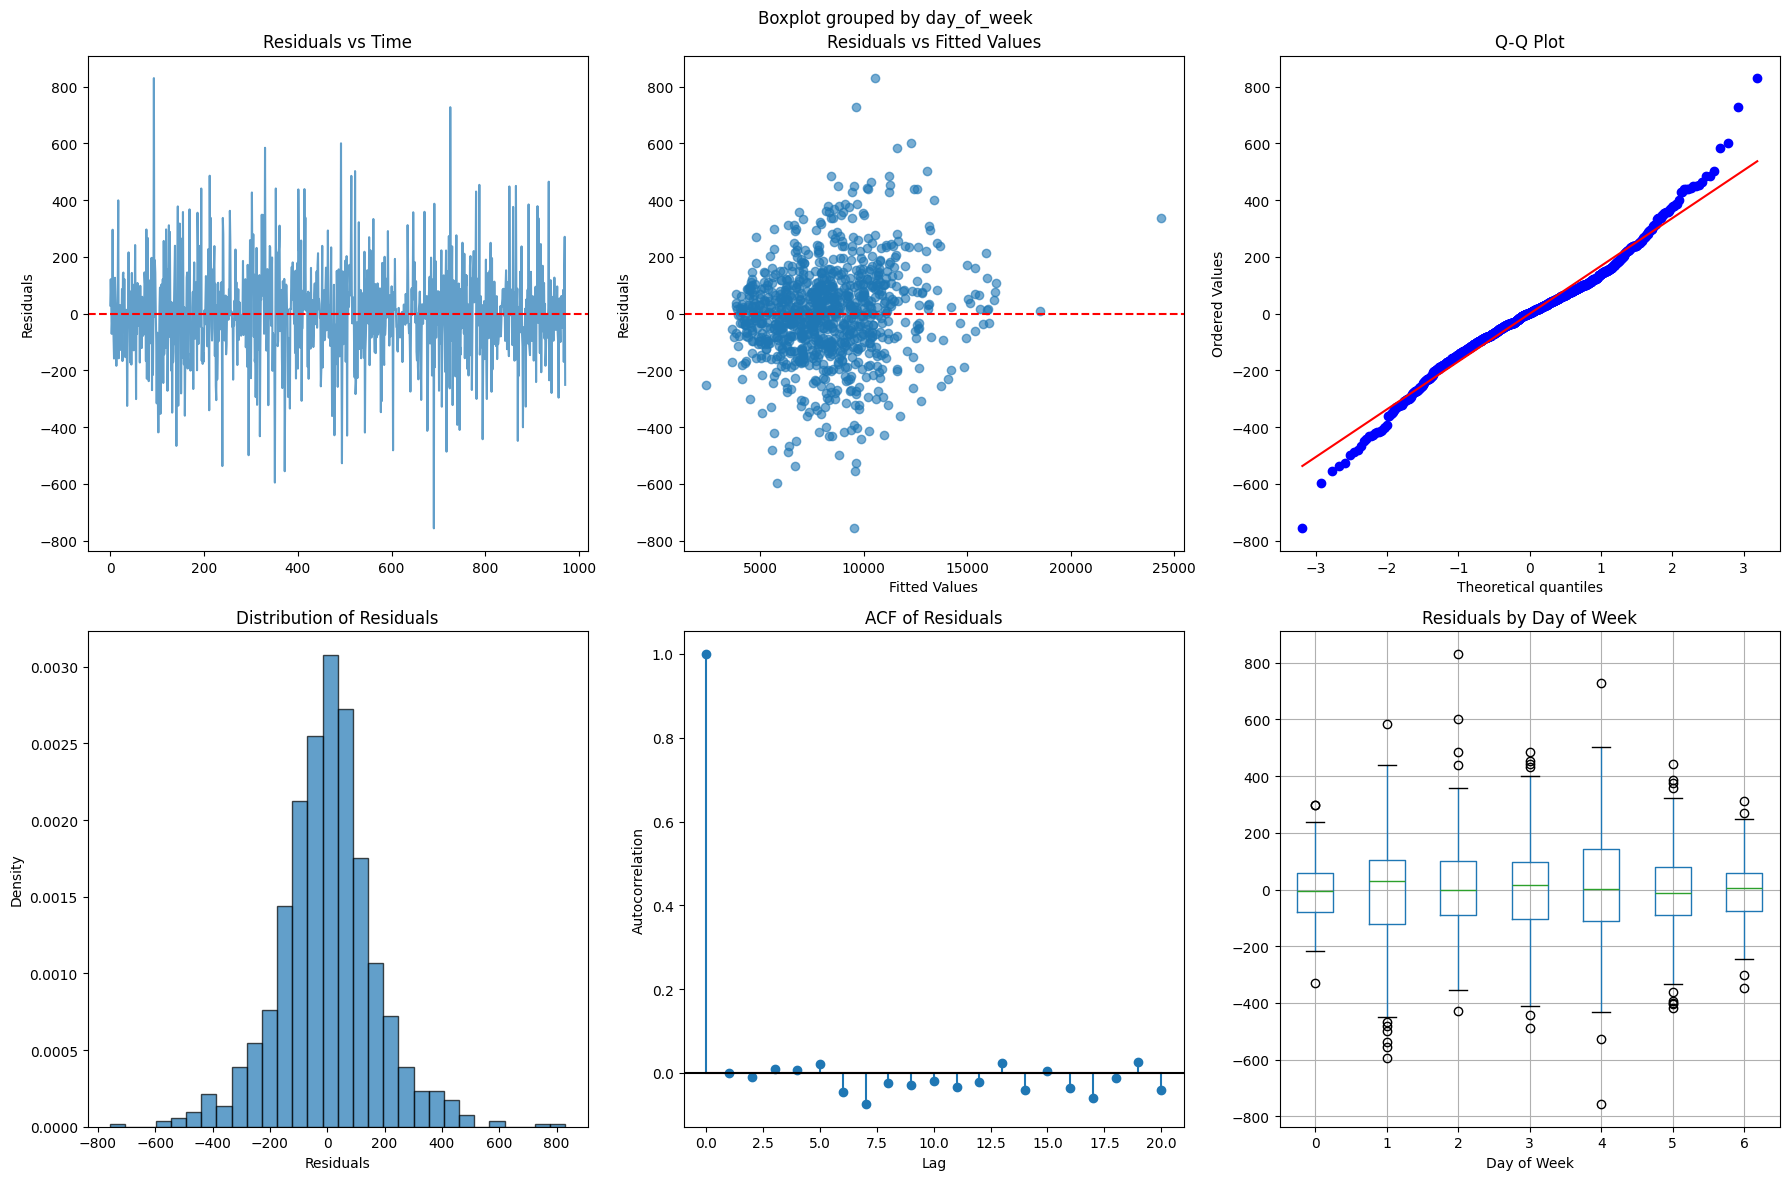


XGBoost - Statistical Tests:
Ljung-Box Test (lag 10): statistic=9.9859, p-value=0.4417
Autocorrelation present: No
Shapiro-Wilk Test: statistic=0.9765, p-value=0.0000
Residuals normally distributed: No
Durbin-Watson Test: 2.0007
Autocorrelation assessment: None


In [7]:
# --- Step 4: Residual Analysis and Model Diagnostics ---

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

def plot_residual_diagnostics(y_true, y_pred, model_name):
    """Comprehensive residual analysis for time series models"""
    residuals = y_true - y_pred

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{model_name} - Residual Diagnostics', fontsize=16, fontweight='bold')

    # 1. Residuals vs Time
    axes[0,0].plot(residuals, alpha=0.7)
    axes[0,0].axhline(y=0, color='red', linestyle='--')
    axes[0,0].set_title('Residuals vs Time')
    axes[0,0].set_ylabel('Residuals')

    # 2. Residuals vs Fitted
    axes[0,1].scatter(y_pred, residuals, alpha=0.6)
    axes[0,1].axhline(y=0, color='red', linestyle='--')
    axes[0,1].set_title('Residuals vs Fitted Values')
    axes[0,1].set_xlabel('Fitted Values')
    axes[0,1].set_ylabel('Residuals')

    # 3. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot')

    # 4. Histogram of Residuals
    axes[1,0].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Residuals')
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Density')

    # 5. ACF of Residuals
    from statsmodels.tsa.stattools import acf
    autocorr = acf(residuals, nlags=20, fft=True)
    axes[1,1].stem(range(len(autocorr)), autocorr)
    axes[1,1].axhline(y=0, color='black', linestyle='-')
    axes[1,1].set_title('ACF of Residuals')
    axes[1,1].set_xlabel('Lag')
    axes[1,1].set_ylabel('Autocorrelation')

    # 6. Box Plot by Day of Week (if applicable)
    if len(residuals) >= 14:  # At least 2 weeks of data
        residual_df = pd.DataFrame({
            'residuals': residuals,
            'day_of_week': [i % 7 for i in range(len(residuals))]
        })
        residual_df.boxplot(column='residuals', by='day_of_week', ax=axes[1,2])
        axes[1,2].set_title('Residuals by Day of Week')
        axes[1,2].set_xlabel('Day of Week')
    else:
        axes[1,2].text(0.5, 0.5, 'Insufficient data\nfor day-of-week analysis',
                      ha='center', va='center', transform=axes[1,2].transAxes)

    plt.tight_layout()
    plt.show()

    # Statistical Tests
    print(f"\n{model_name} - Statistical Tests:")
    print("="*50)

    # Ljung-Box Test for autocorrelation - FIXED
    try:
        lb_result = acorr_ljungbox(residuals, lags=10, return_df=True)
        lb_stat = lb_result['lb_stat'].iloc[-1]  # Get the last lag statistic
        lb_pvalue = lb_result['lb_pvalue'].iloc[-1]  # Get the last lag p-value
        print(f"Ljung-Box Test (lag 10): statistic={lb_stat:.4f}, p-value={lb_pvalue:.4f}")
        print(f"Autocorrelation present: {'Yes' if lb_pvalue < 0.05 else 'No'}")
    except Exception as e:
        print(f"Ljung-Box Test failed: {str(e)}")

    # Shapiro-Wilk Test for normality
    if len(residuals) <= 5000:  # Shapiro-Wilk limitation
        try:
            sw_stat, sw_pvalue = stats.shapiro(residuals)
            print(f"Shapiro-Wilk Test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.4f}")
            print(f"Residuals normally distributed: {'Yes' if sw_pvalue > 0.05 else 'No'}")
        except Exception as e:
            print(f"Shapiro-Wilk Test failed: {str(e)}")

    # Durbin-Watson Test for autocorrelation
    try:
        from statsmodels.stats.stattools import durbin_watson
        dw_stat = durbin_watson(residuals)
        print(f"Durbin-Watson Test: {dw_stat:.4f}")
        print(f"Autocorrelation assessment: {'Positive' if dw_stat < 1.5 else 'None' if 1.5 <= dw_stat <= 2.5 else 'Negative'}")
    except Exception as e:
        print(f"Durbin-Watson Test failed: {str(e)}")

# Apply residual analysis to champion model
print("=== RESIDUAL ANALYSIS FOR CHAMPION MODEL ===")

# Retrain champion model on full dataset for residual analysis
champion_name = champion_model
if champion_name == 'XGBoost':
    champion_fitted = XGBRegressor(learning_rate=0.1, n_estimators=100, random_state=42)
    champion_fitted.fit(X, y)
    y_pred_full = champion_fitted.predict(X)
elif champion_name == 'RandomForest':
    champion_fitted = RandomForestRegressor(max_depth=20, n_estimators=100, random_state=42)
    champion_fitted.fit(X, y)
    y_pred_full = champion_fitted.predict(X)

plot_residual_diagnostics(y.values, y_pred_full, champion_name)


=== FEATURE IMPORTANCE ANALYSIS ===


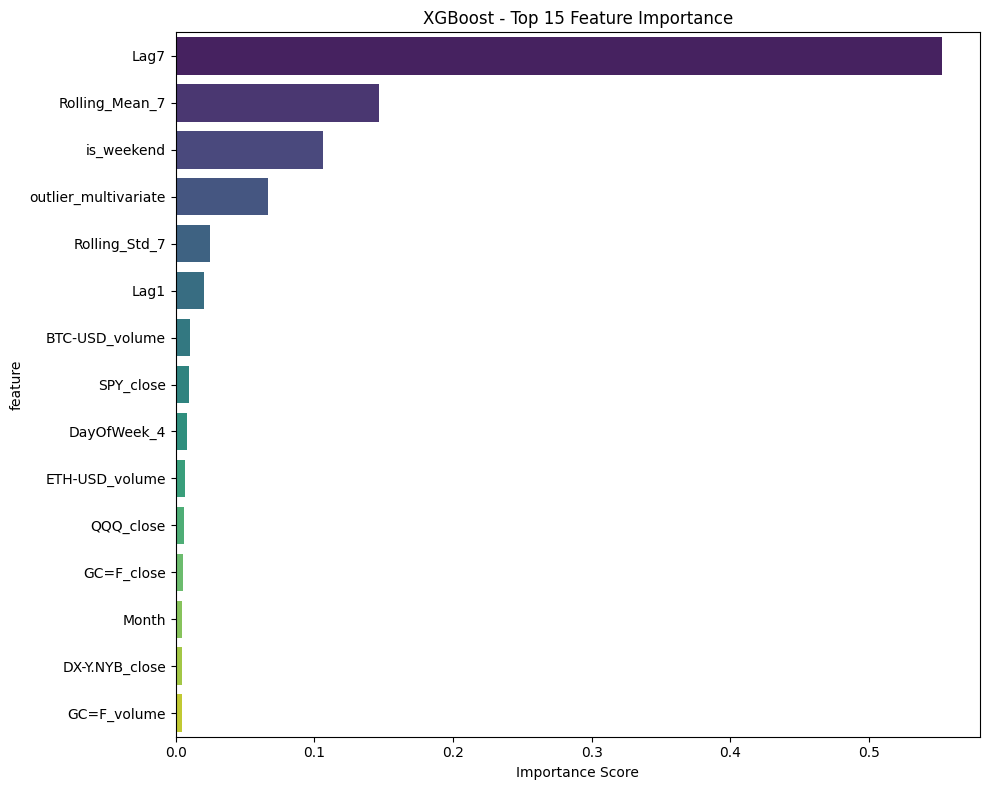


Top 10 Most Important Features for XGBoost:
             feature  importance
                Lag7    0.552335
      Rolling_Mean_7    0.146918
          is_weekend    0.105931
outlier_multivariate    0.066660
       Rolling_Std_7    0.024549
                Lag1    0.020606
      BTC-USD_volume    0.010692
           SPY_close    0.009626
         DayOfWeek_4    0.008075
      ETH-USD_volume    0.006720


In [8]:
# --- Step 5: Feature Importance Analysis (for ML models) ---

def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis')
        plt.title(f'{model_name} - Top {top_n} Feature Importance')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        print(f"Feature importance not available for {model_name}")
        return None

print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
feature_importance_df = plot_feature_importance(champion_fitted, X.columns, champion_name)
if feature_importance_df is not None:
    print(f"\nTop 10 Most Important Features for {champion_name}:")
    print(feature_importance_df.head(10).to_string(index=False))


=== WALK-FORWARD VALIDATION ===
Walk-Forward Validation: window_size=323, step_size=1
Progress: ................................ Done!


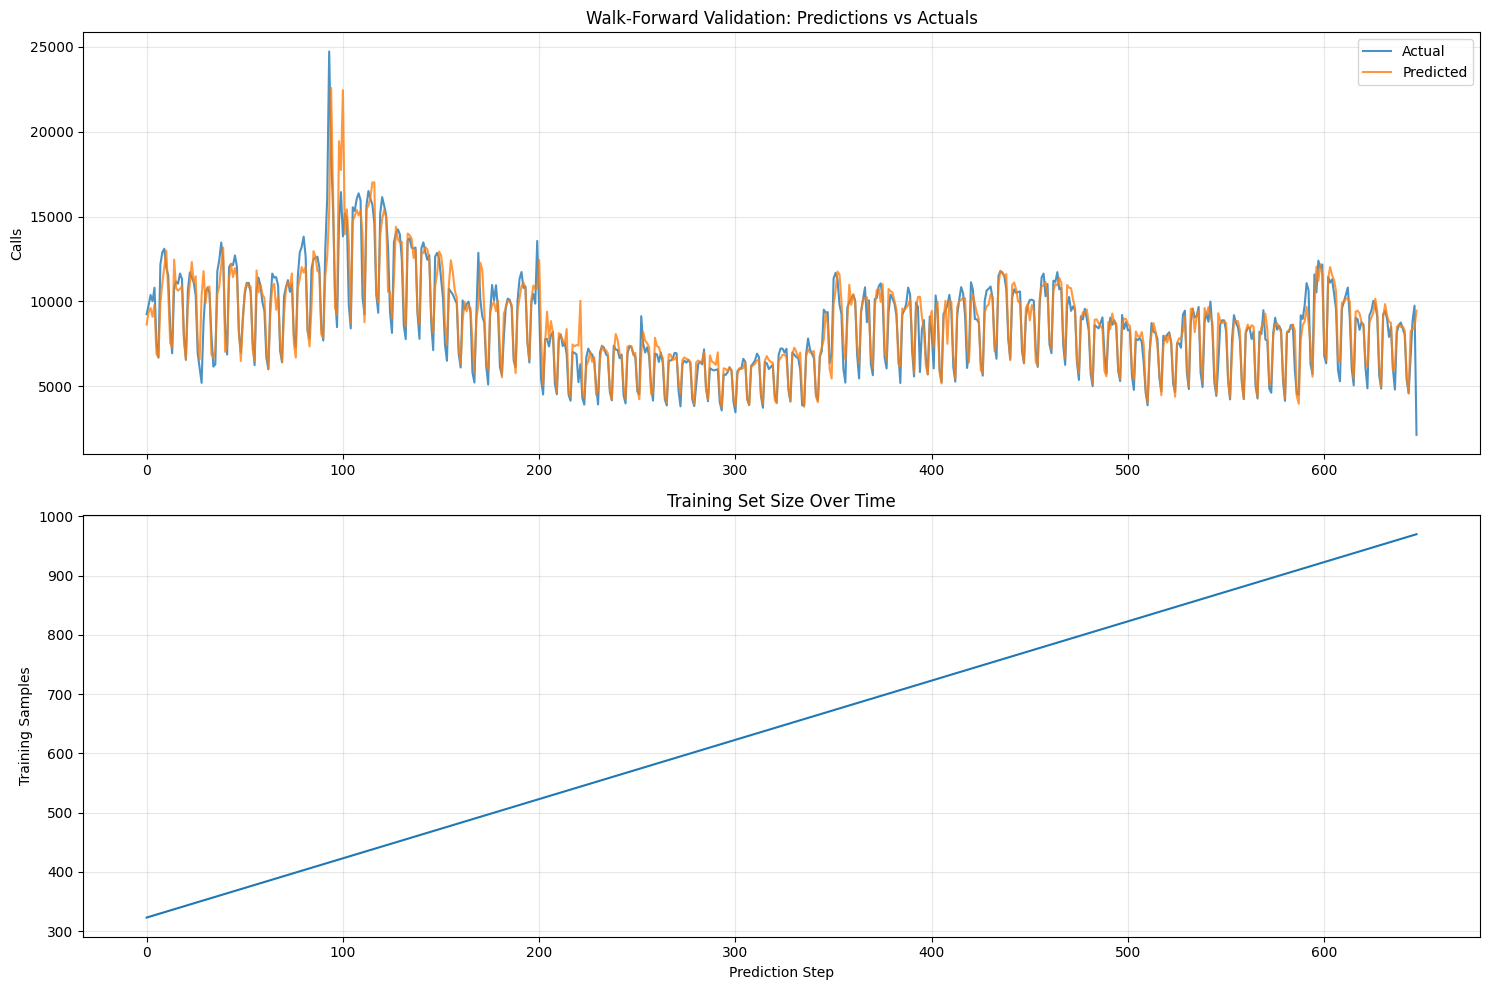


Walk-Forward Validation Results for XGBoost:
MAE: 640.11
RMSE: 1063.33
MAPE: 7.87
MASE: 0.75


In [9]:
# --- Step 6: Walk-Forward Validation ---

def walk_forward_validation(X, y, model, window_size=None, step_size=1):
    """Perform walk-forward validation to simulate real-world deployment"""
    if window_size is None:
        window_size = len(X) // 3  # Use 1/3 of data as initial training window

    predictions = []
    actuals = []
    train_sizes = []

    start_idx = window_size

    print(f"Walk-Forward Validation: window_size={window_size}, step_size={step_size}")
    print("Progress: ", end="")

    for i in range(start_idx, len(X), step_size):
        if i >= len(X):
            break

        # Expanding window (growing training set)
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]

        # Single step prediction
        X_test = X.iloc[i:i+1]
        y_test = y.iloc[i:i+1]

        # Train and predict
        model_clone = model.__class__(**model.get_params())
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)

        predictions.extend(y_pred)
        actuals.extend(y_test.values)
        train_sizes.append(len(X_train))

        if i % 20 == 0:
            print(".", end="")

    print(" Done!")

    wfv_metrics = calculate_metrics(np.array(actuals), np.array(predictions))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Predictions vs Actuals
    ax1.plot(actuals, label='Actual', alpha=0.8)
    ax1.plot(predictions, label='Predicted', alpha=0.8)
    ax1.set_title('Walk-Forward Validation: Predictions vs Actuals')
    ax1.set_ylabel('Calls')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Training set size over time
    ax2.plot(train_sizes)
    ax2.set_title('Training Set Size Over Time')
    ax2.set_xlabel('Prediction Step')
    ax2.set_ylabel('Training Samples')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return wfv_metrics, actuals, predictions

print("\n=== WALK-FORWARD VALIDATION ===")
wfv_metrics, wfv_actuals, wfv_predictions = walk_forward_validation(X, y, champion_fitted)
print(f"\nWalk-Forward Validation Results for {champion_name}:")
for metric, value in wfv_metrics.items():
    print(f"{metric}: {value:.2f}")


=== SHAP ANALYSIS FOR MODEL INTERPRETABILITY ===


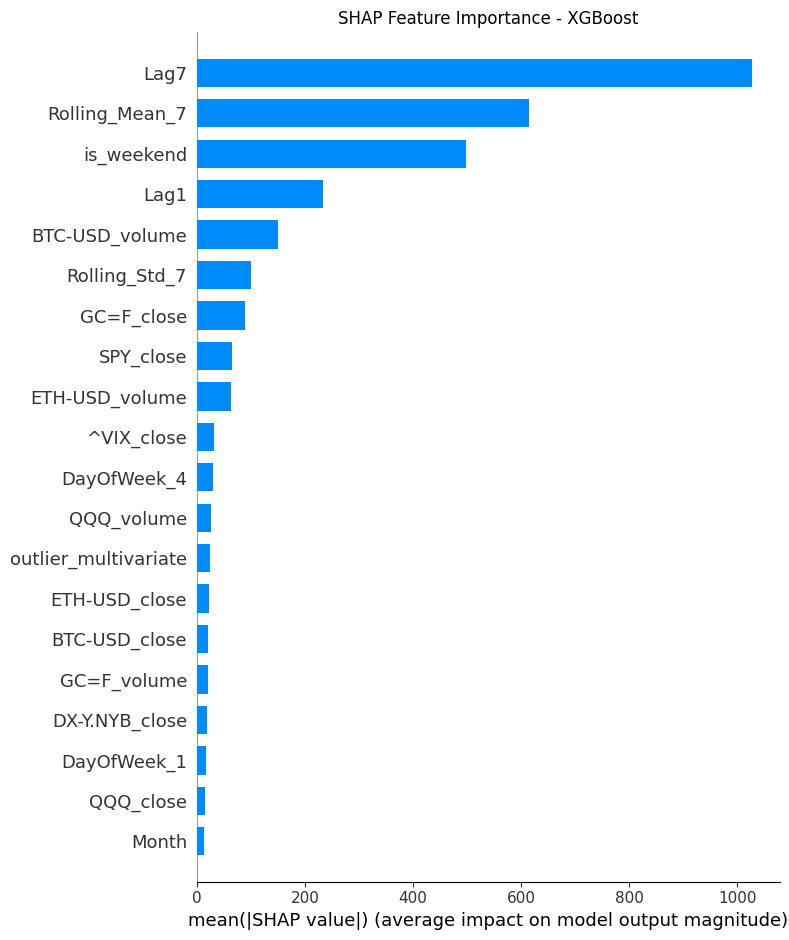

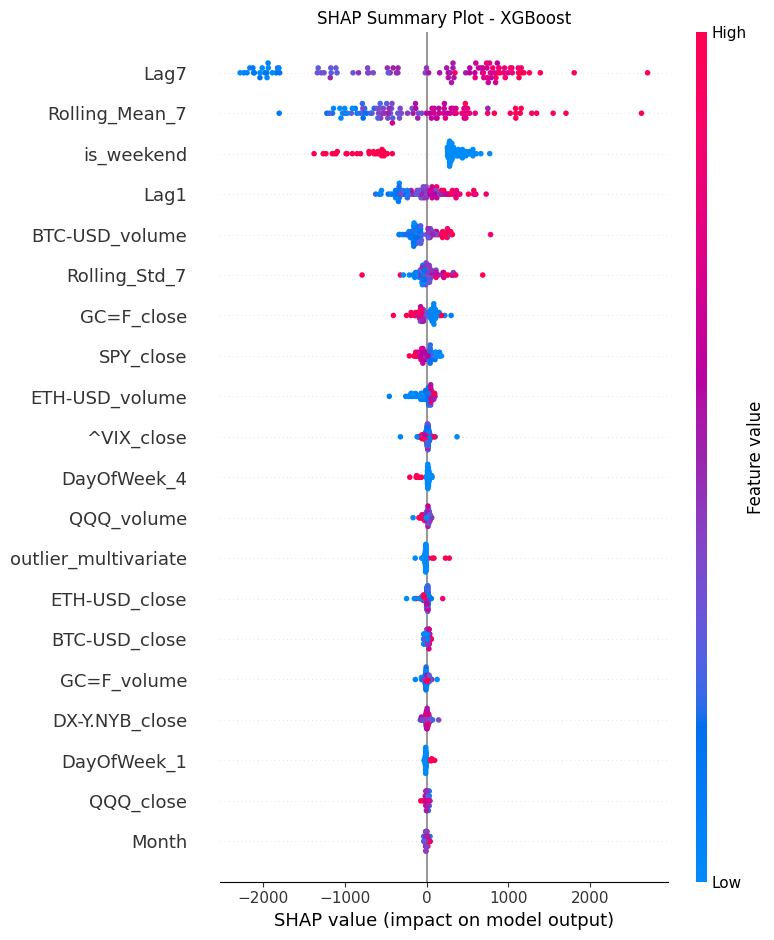

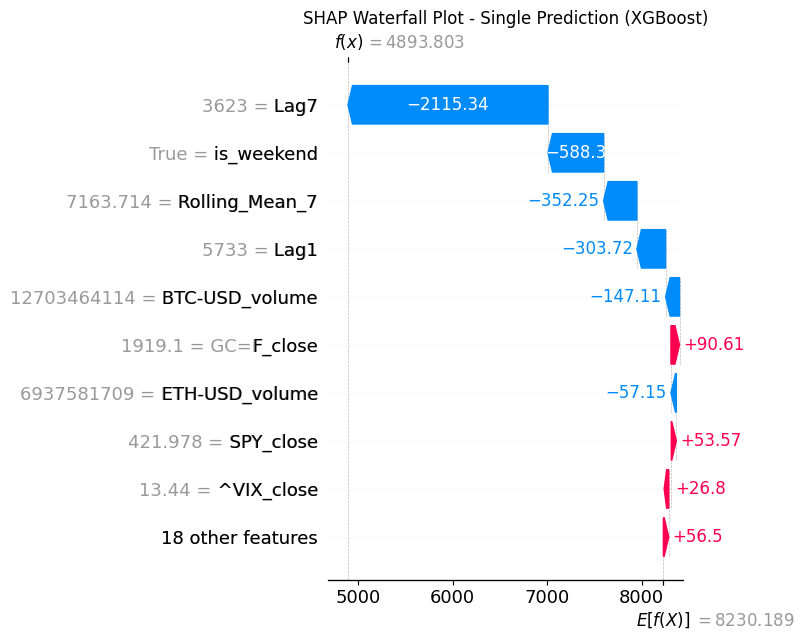

In [11]:
# --- Step 7: Model Interpretability with SHAP (for ML models) ---

try:
    import shap

    print("\n=== SHAP ANALYSIS FOR MODEL INTERPRETABILITY ===")

    # Use a smaller sample to avoid memory issues
    sample_size = min(100, len(X))
    X_sample = X.sample(sample_size, random_state=42)

    # Initialize SHAP explainer with different methods based on model type
    if champion_name == 'XGBoost':
        # For XGBoost, use TreeExplainer which is more efficient
        explainer = shap.TreeExplainer(champion_fitted)
        shap_values = explainer.shap_values(X_sample)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {champion_name}')
        plt.tight_layout()
        plt.show()

        # Detailed summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, show=False)
        plt.title(f'SHAP Summary Plot - {champion_name}')
        plt.tight_layout()
        plt.show()

        # Waterfall plot for a single prediction
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                           base_values=explainer.expected_value,
                                           data=X_sample.iloc[0].values,
                                           feature_names=X_sample.columns.tolist()),
                           show=False)
        plt.title(f'SHAP Waterfall Plot - Single Prediction ({champion_name})')
        plt.tight_layout()
        plt.show()

    elif champion_name == 'RandomForest':
        # For RandomForest, use TreeExplainer
        explainer = shap.TreeExplainer(champion_fitted)
        shap_values = explainer.shap_values(X_sample)

        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance - {champion_name}')
        plt.tight_layout()
        plt.show()

        # Waterfall plot for a single prediction
        plt.figure(figsize=(10, 6))
        shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                           base_values=explainer.expected_value,
                                           data=X_sample.iloc[0].values,
                                           feature_names=X_sample.columns.tolist()),
                           show=False)
        plt.title(f'SHAP Waterfall Plot - Single Prediction ({champion_name})')
        plt.tight_layout()
        plt.show()

    else:
        # Fallback for other model types
        print(f"SHAP analysis not specifically implemented for {champion_name}")
        print("You can implement custom SHAP analysis for this model type.")

except ImportError:
    print("SHAP not available. Installing SHAP...")
    import subprocess
    import sys

    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        print("SHAP installed successfully! Please re-run this cell.")
    except Exception as install_error:
        print(f"Failed to install SHAP automatically: {install_error}")
        print("Please manually install SHAP by running: !pip install shap")

except Exception as e:
    print(f"SHAP analysis failed with error: {str(e)}")
    print(f"Error type: {type(e).__name__}")

    # Provide alternative feature importance analysis
    print("\nFalling back to built-in feature importance...")
    if hasattr(champion_fitted, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': X.columns,
            'importance': champion_fitted.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(15), y='feature', x='importance', palette='viridis')
        plt.title(f'{champion_name} - Feature Importance (Fallback)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        print("Top 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))
    else:
        print("No feature importance available for this model type.")


=== PREDICTION QUALITY ANALYSIS ===


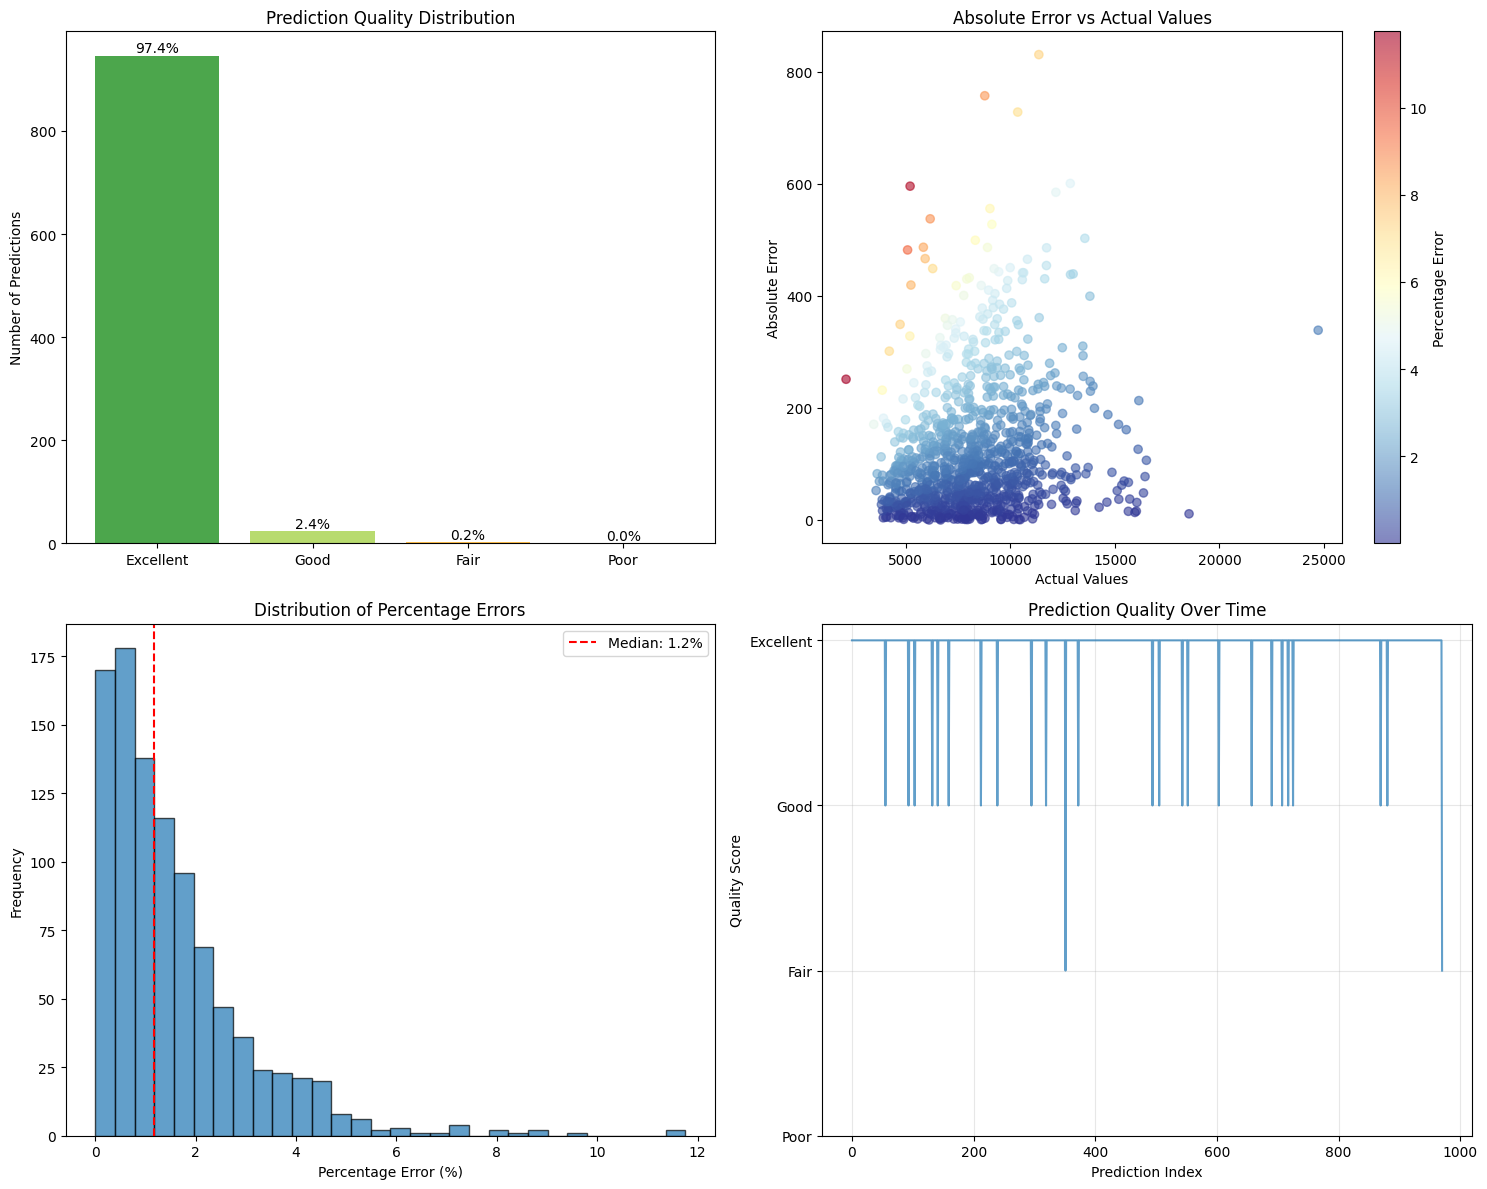


XGBoost - Prediction Quality Summary:
Excellent predictions (≤5% error): 946 (97.4%)
Good predictions (5-10% error): 23 (2.4%)
Fair predictions (10-20% error): 2 (0.2%)
Poor predictions (>20% error): 0 (0.0%)

Overall acceptable predictions (≤10% error): 969 (99.8%)


In [12]:
# --- Step 8: Prediction Quality Analysis ---

def analyze_prediction_quality(y_true, y_pred, model_name):
    """Analyze prediction quality with categorical breakdowns"""

    # Calculate error metrics
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    pct_errors = np.abs(errors) / y_true * 100

    # Define quality categories based on percentage error
    def categorize_prediction_quality(pct_error):
        if pct_error <= 5:
            return 'Excellent'
        elif pct_error <= 10:
            return 'Good'
        elif pct_error <= 20:
            return 'Fair'
        else:
            return 'Poor'

    quality_categories = [categorize_prediction_quality(pe) for pe in pct_errors]

    # Create prediction quality "confusion matrix" equivalent
    from collections import Counter
    quality_counts = Counter(quality_categories)

    # Plot quality distribution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Quality Categories Bar Chart
    categories = ['Excellent', 'Good', 'Fair', 'Poor']
    counts = [quality_counts.get(cat, 0) for cat in categories]
    percentages = [count/len(quality_categories)*100 for count in counts]

    colors = ['green', 'yellowgreen', 'orange', 'red']
    bars = ax1.bar(categories, counts, color=colors, alpha=0.7)
    ax1.set_title('Prediction Quality Distribution')
    ax1.set_ylabel('Number of Predictions')

    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{pct:.1f}%', ha='center', va='bottom')

    # 2. Error vs Actual Values
    scatter = ax2.scatter(y_true, abs_errors, c=pct_errors, cmap='RdYlBu_r', alpha=0.6)
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Absolute Error')
    ax2.set_title('Absolute Error vs Actual Values')
    plt.colorbar(scatter, ax=ax2, label='Percentage Error')

    # 3. Percentage Error Distribution
    ax3.hist(pct_errors, bins=30, alpha=0.7, edgecolor='black')
    ax3.axvline(np.median(pct_errors), color='red', linestyle='--', label=f'Median: {np.median(pct_errors):.1f}%')
    ax3.set_xlabel('Percentage Error (%)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Percentage Errors')
    ax3.legend()

    # 4. Time Series of Quality Categories
    quality_numeric = [4 if q=='Excellent' else 3 if q=='Good' else 2 if q=='Fair' else 1 for q in quality_categories]
    ax4.plot(quality_numeric, alpha=0.7)
    ax4.set_ylabel('Quality Score')
    ax4.set_xlabel('Prediction Index')
    ax4.set_title('Prediction Quality Over Time')
    ax4.set_yticks([1, 2, 3, 4])
    ax4.set_yticklabels(['Poor', 'Fair', 'Good', 'Excellent'])
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{model_name} - Prediction Quality Summary:")
    print("="*50)
    print(f"Excellent predictions (≤5% error): {quality_counts.get('Excellent', 0)} ({quality_counts.get('Excellent', 0)/len(quality_categories)*100:.1f}%)")
    print(f"Good predictions (5-10% error): {quality_counts.get('Good', 0)} ({quality_counts.get('Good', 0)/len(quality_categories)*100:.1f}%)")
    print(f"Fair predictions (10-20% error): {quality_counts.get('Fair', 0)} ({quality_counts.get('Fair', 0)/len(quality_categories)*100:.1f}%)")
    print(f"Poor predictions (>20% error): {quality_counts.get('Poor', 0)} ({quality_counts.get('Poor', 0)/len(quality_categories)*100:.1f}%)")

    acceptable_predictions = quality_counts.get('Excellent', 0) + quality_counts.get('Good', 0)
    print(f"\nOverall acceptable predictions (≤10% error): {acceptable_predictions} ({acceptable_predictions/len(quality_categories)*100:.1f}%)")

    return quality_categories

print("\n=== PREDICTION QUALITY ANALYSIS ===")
quality_cats = analyze_prediction_quality(y.values, y_pred_full, champion_name)


=== FINAL HOLDOUT TEST (Last 30 days) ===


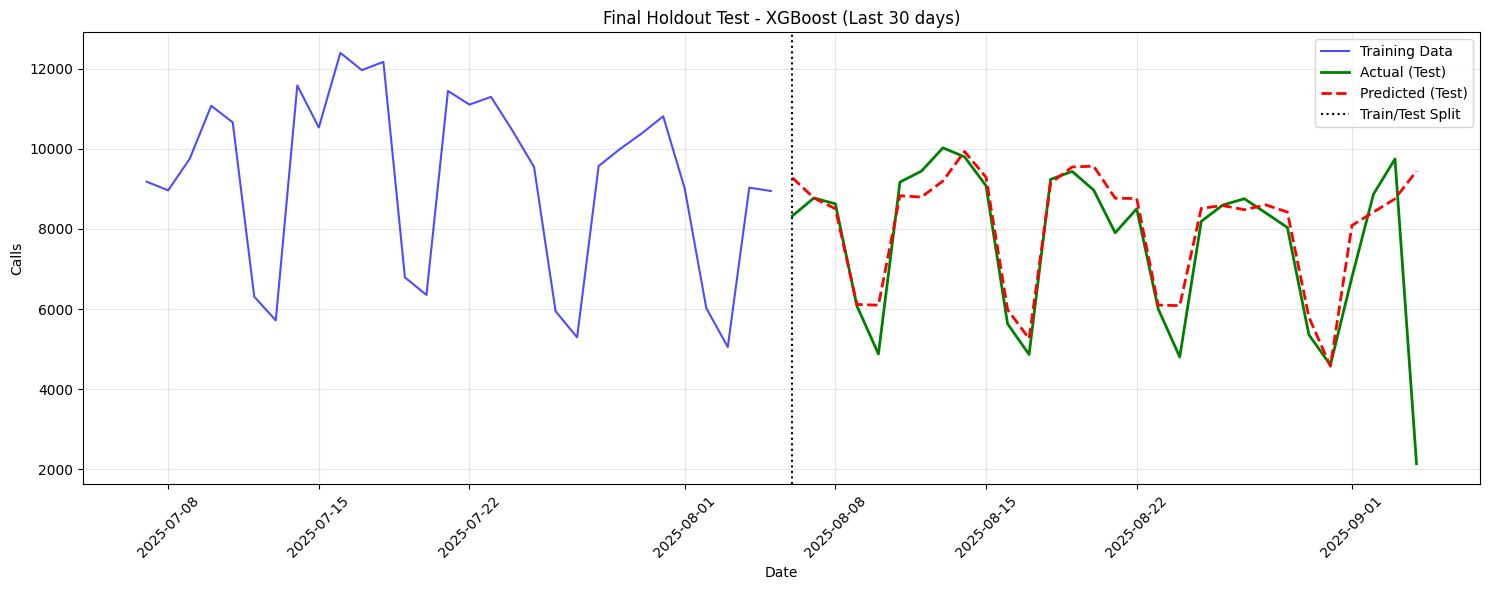


Final Holdout Test Results for XGBoost:
MAE: 675.30
RMSE: 1457.03
MAPE: 17.54
MASE: 0.79


In [13]:
# --- Step 9: Out-of-Sample Testing on Most Recent Data ---

def final_holdout_test(X, y, model, test_size=30):
    """Final test on most recent data (holdout set)"""
    split_idx = len(X) - test_size

    X_train_final = X.iloc[:split_idx]
    y_train_final = y.iloc[:split_idx]
    X_test_final = X.iloc[split_idx:]
    y_test_final = y.iloc[split_idx:]

    # Train final model
    final_model = model.__class__(**model.get_params())
    final_model.fit(X_train_final, y_train_final)

    # Make predictions
    y_pred_final = final_model.predict(X_test_final)

    # Calculate metrics
    final_metrics = calculate_metrics(y_test_final.values, y_pred_final)

    # Plot results
    plt.figure(figsize=(15, 6))

    # Plot last 60 days for context
    context_start = max(0, split_idx - 30)
    context_dates = y.index[context_start:]
    context_actual = y.iloc[context_start:]

    plt.plot(context_dates[:split_idx-context_start],
             context_actual.iloc[:split_idx-context_start],
             label='Training Data', color='blue', alpha=0.7)
    plt.plot(context_dates[split_idx-context_start:],
             y_test_final.values,
             label='Actual (Test)', color='green', linewidth=2)
    plt.plot(context_dates[split_idx-context_start:],
             y_pred_final,
             label='Predicted (Test)', color='red', linewidth=2, linestyle='--')

    plt.axvline(x=y.index[split_idx], color='black', linestyle=':', label='Train/Test Split')
    plt.title(f'Final Holdout Test - {champion_name} (Last {test_size} days)')
    plt.xlabel('Date')
    plt.ylabel('Calls')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return final_metrics, final_model, y_pred_final

print(f"\n=== FINAL HOLDOUT TEST (Last 30 days) ===")
final_metrics, final_model, y_pred_final = final_holdout_test(X, y, champion_fitted, test_size=30)
print(f"\nFinal Holdout Test Results for {champion_name}:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.2f}")

In [14]:
# --- Step 10: Model Performance Summary Report ---

def generate_performance_report():
    """Generate comprehensive performance summary"""

    print("\n" + "="*80)
    print("COMPREHENSIVE MODEL PERFORMANCE REPORT")
    print("="*80)

    print(f"\n🏆 CHAMPION MODEL: {champion_name}")
    print("-" * 40)

    print("\n📊 CROSS-VALIDATION RESULTS:")
    for metric, value in all_metrics[champion_name].items():
        print(f"  {metric}: {value:.2f}")

    print(f"\n🚶 WALK-FORWARD VALIDATION RESULTS:")
    for metric, value in wfv_metrics.items():
        print(f"  {metric}: {value:.2f}")

    print(f"\n🎯 FINAL HOLDOUT TEST RESULTS:")
    for metric, value in final_metrics.items():
        print(f"  {metric}: {value:.2f}")

    print(f"\n📈 MODEL CONSISTENCY:")
    cv_mae = all_metrics[champion_name]['MAE']
    wfv_mae = wfv_metrics['MAE']
    holdout_mae = final_metrics['MAE']

    mae_std = np.std([cv_mae, wfv_mae, holdout_mae])
    mae_cv = mae_std / np.mean([cv_mae, wfv_mae, holdout_mae]) * 100

    print(f"  MAE Standard Deviation: {mae_std:.2f}")
    print(f"  MAE Coefficient of Variation: {mae_cv:.1f}%")
    print(f"  Consistency Rating: {'Excellent' if mae_cv < 10 else 'Good' if mae_cv < 20 else 'Fair' if mae_cv < 30 else 'Poor'}")

    print(f"\n🔧 RECOMMENDED ACTIONS:")
    if mae_cv > 20:
        print("  • Consider ensemble methods or model regularization")
        print("  • Investigate data quality and feature engineering")
    if final_metrics['MASE'] > 1:
        print("  • Model performs worse than seasonal naive - consider simpler approaches")
    if final_metrics['MAPE'] > 20:
        print("  • High prediction error - consider additional features or different algorithms")
    else:
        print("  • Model performance is satisfactory for production use")
        print("  • Implement monitoring and periodic retraining")

    print("\n" + "="*80)

generate_performance_report()

# --- Step 11: Save Final Model and Predictions ---

import joblib
from datetime import datetime

# Save the final trained model
model_filename = f"final_{champion_name.lower()}_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
joblib.dump(final_model, model_filename)
print(f"\n💾 Final model saved as: {model_filename}")

# Save predictions and actuals for further analysis
results_df = pd.DataFrame({
    'date': y.index[-30:],  # Last 30 days
    'actual': y.iloc[-30:].values,
    'predicted': y_pred_final,
    'residual': y.iloc[-30:].values - y_pred_final,
    'abs_error': np.abs(y.iloc[-30:].values - y_pred_final),
    'pct_error': (y.iloc[-30:].values - y_pred_final) / y.iloc[-30:].values * 100
})

results_filename = f"prediction_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
results_df.to_csv(results_filename, index=False)
print(f"📊 Prediction results saved as: {results_filename}")

print("\n✅ ANALYSIS COMPLETE!")
print("=" * 50)


COMPREHENSIVE MODEL PERFORMANCE REPORT

🏆 CHAMPION MODEL: XGBoost
----------------------------------------

📊 CROSS-VALIDATION RESULTS:
  MAE: 123.10
  RMSE: 168.18
  MAPE: 1.53
  MASE: 0.14

🚶 WALK-FORWARD VALIDATION RESULTS:
  MAE: 640.11
  RMSE: 1063.33
  MAPE: 7.87
  MASE: 0.75

🎯 FINAL HOLDOUT TEST RESULTS:
  MAE: 675.30
  RMSE: 1457.03
  MAPE: 17.54
  MASE: 0.79

📈 MODEL CONSISTENCY:
  MAE Standard Deviation: 252.43
  MAE Coefficient of Variation: 52.6%
  Consistency Rating: Poor

🔧 RECOMMENDED ACTIONS:
  • Consider ensemble methods or model regularization
  • Investigate data quality and feature engineering
  • Model performance is satisfactory for production use
  • Implement monitoring and periodic retraining


💾 Final model saved as: final_xgboost_model_20250918_042503.pkl
📊 Prediction results saved as: prediction_results_20250918_042503.csv

✅ ANALYSIS COMPLETE!


In [15]:
# Alternative: Text representation of tree
if champion_name == 'XGBoost':
    try:
        # Get the first tree as text
        booster = champion_fitted.get_booster()
        tree_dump = booster.get_dump()[0]  # First tree

        print("First Tree Structure (Text):")
        print("=" * 40)
        print(tree_dump[:1000] + "..." if len(tree_dump) > 1000 else tree_dump)

    except Exception as e:
        print(f"Text tree dump failed: {e}")

First Tree Structure (Text):
0:[Lag7<7827] yes=1,no=2,missing=2
	1:[Lag7<5862] yes=3,no=4,missing=4
		3:[Rolling_Mean_7<7845.85693] yes=7,no=8,missing=8
7:[is_weekend] yes=15,no=16
				15:leaf=-169.072906
				16:[Lag1<7312] yes=29,no=30,missing=30
					29:leaf=-368.909393
					30:leaf=-264.522095
			8:[BTC-USD_volume<-2147483648] yes=17,no=18,missing=18
				17:leaf=-81.5196304
				18:[BTC-USD_volume<-2147483648] yes=31,no=32,missing=32
					31:[^VIX_close<22.3799992] yes=51,no=52,missing=52
						51:leaf=-245.035019
						52:leaf=-86.0507812
					32:leaf=-103.819633
		4:[Lag7<7066] yes=9,no=10,missing=10
			9:[BTC-USD_volume<-2147483648] yes=19,no=20,missing=20
19:[is_weekend] yes=33,no=34
					33:[Rolling_Mean_7<6790.85693] yes=53,no=54,missing=54
						53:leaf=-156.461838
						54:leaf=22.9971275
					34:[Lag1<10193] yes=55,no=56,missing=56
						55:leaf=-218.294022
						56:leaf=-79.4035568
				20:[BTC-USD_close<76271.9531] yes=35,no=36,missing=36
					35:leaf=66.8825531
					36:lea


=== XGBOOST TREE VISUALIZATION ===
XGBoost model has 100 trees


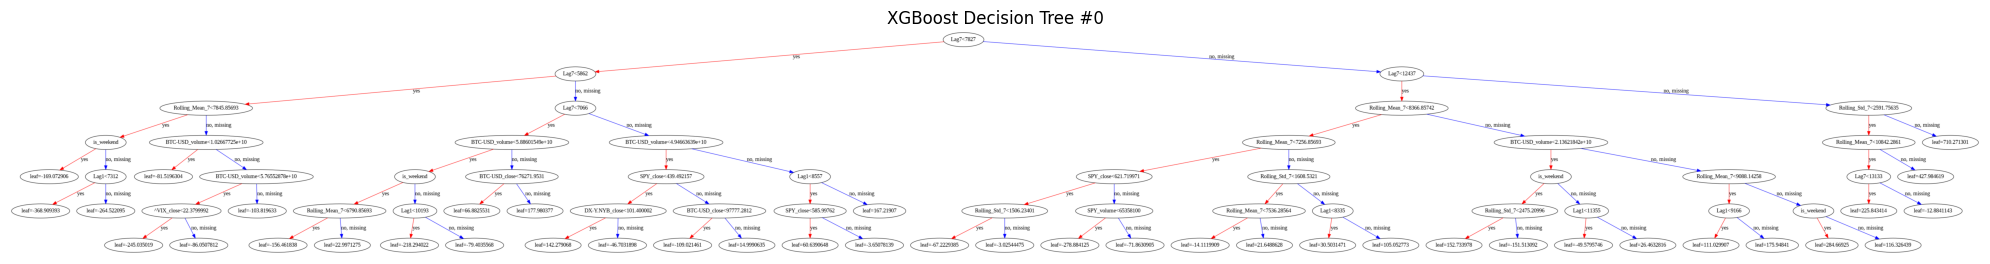

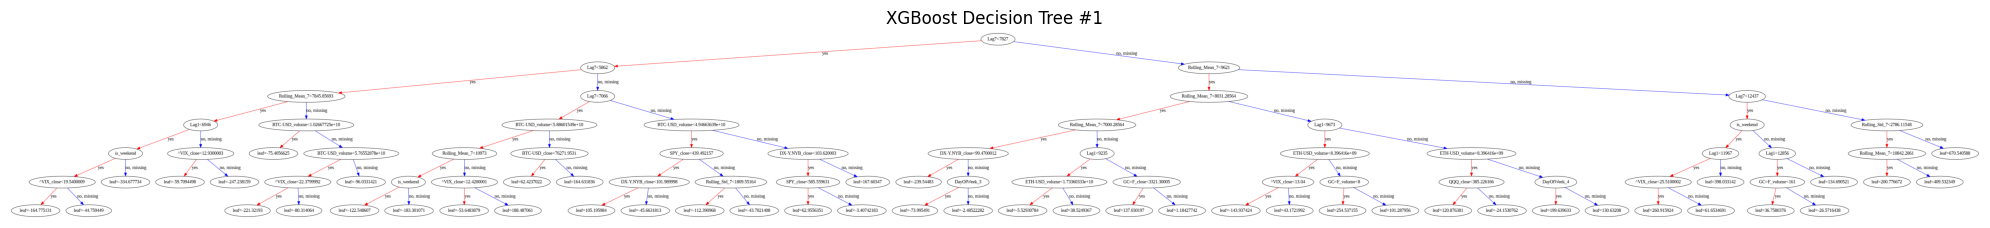

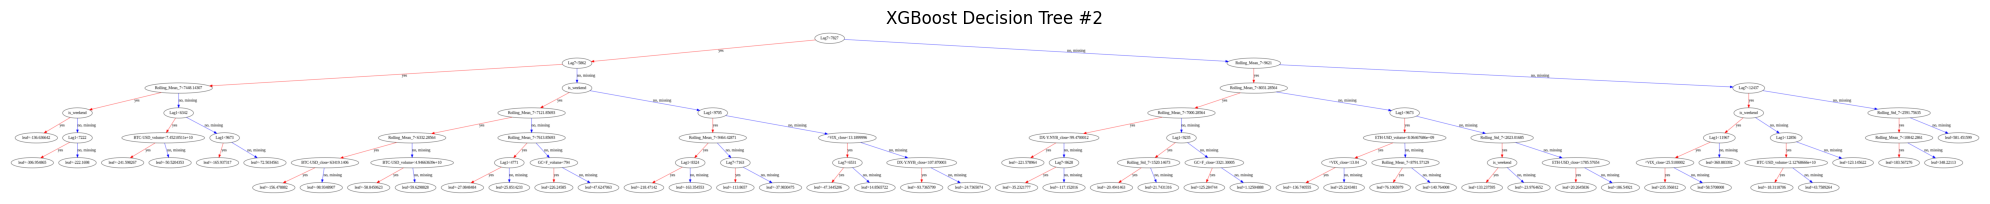


Tree Statistics:
Number of trees: 100
Max depth: None
Learning rate: 0.1

Top 10 Features by Split Frequency:
  ^VIX_close: 395.0 splits
  Lag1: 316.0 splits
  Rolling_Mean_7: 293.0 splits
  BTC-USD_volume: 291.0 splits
  Rolling_Std_7: 285.0 splits
  Lag7: 228.0 splits
  SPY_close: 177.0 splits
  DX-Y.NYB_close: 175.0 splits
  GC=F_close: 175.0 splits
  GC=F_volume: 169.0 splits


In [16]:
# --- Step 8: XGBoost Tree Visualization ---

print("\n=== XGBOOST TREE VISUALIZATION ===")

if champion_name == 'XGBoost':
    try:
        import xgboost as xgb
        from xgboost import plot_tree
        import matplotlib.pyplot as plt

        print(f"XGBoost model has {champion_fitted.n_estimators} trees")

        # Plot the first few trees
        trees_to_plot = min(3, champion_fitted.n_estimators)  # Plot first 3 trees

        for i in range(trees_to_plot):
            plt.figure(figsize=(20, 10))
            plot_tree(champion_fitted, num_trees=i, rankdir='TB', ax=plt.gca())
            plt.title(f'XGBoost Decision Tree #{i}')
            plt.tight_layout()
            plt.show()

        # Tree statistics
        print(f"\nTree Statistics:")
        print(f"Number of trees: {champion_fitted.n_estimators}")
        print(f"Max depth: {champion_fitted.max_depth}")
        print(f"Learning rate: {champion_fitted.learning_rate}")

        # Feature importance from trees
        feature_importance = champion_fitted.get_booster().get_score(importance_type='weight')
        print(f"\nTop 10 Features by Split Frequency:")
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        for feature, count in sorted_features[:10]:
            print(f"  {feature}: {count} splits")

    except ImportError:
        print("xgboost plotting functions not available. Install with: pip install xgboost[plotting]")
    except Exception as e:
        print(f"Tree visualization failed: {e}")

        # Alternative: Show feature splits information
        try:
            booster = champion_fitted.get_booster()
            feature_importance = booster.get_score(importance_type='weight')
            gain_importance = booster.get_score(importance_type='gain')

            print("\nFeature Importance (Alternative View):")
            print("=" * 50)
            print("By Split Frequency (weight):")
            sorted_weight = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
            for feature, weight in sorted_weight[:10]:
                print(f"  {feature}: {weight} splits")

            print("\nBy Information Gain:")
            sorted_gain = sorted(gain_importance.items(), key=lambda x: x[1], reverse=True)
            for feature, gain in sorted_gain[:10]:
                print(f"  {feature}: {gain:.4f} gain")

        except Exception as e2:
            print(f"Alternative feature analysis also failed: {e2}")

else:
    print(f"Tree visualization only available for XGBoost models. Current champion: {champion_name}")

    # For RandomForest, you can visualize individual trees differently
    if champion_name == 'RandomForest':
        try:
            from sklearn.tree import plot_tree as sklearn_plot_tree

            print("Visualizing first tree from Random Forest:")
            plt.figure(figsize=(25, 15))
            sklearn_plot_tree(champion_fitted.estimators_[0],
                            feature_names=X.columns,
                            max_depth=3,  # Limit depth for readability
                            filled=True,
                            fontsize=10)
            plt.title('Random Forest - First Tree (Limited to Depth 3)')
            plt.tight_layout()
            plt.show()

            print(f"\nRandom Forest has {champion_fitted.n_estimators} trees")
            print(f"Each tree max depth: {champion_fitted.max_depth}")

        except Exception as e:
            print(f"Random Forest tree visualization failed: {e}")

In [17]:
# --- Save All Visualizations to PDF ---

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns

def save_all_visualizations_to_pdf():
    """Generate and save all key visualizations to a single PDF report"""

    # Create PDF filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    pdf_filename = f"call_center_model_report_{timestamp}.pdf"

    print(f"Generating comprehensive visualization report: {pdf_filename}")

    with PdfPages(pdf_filename) as pdf:

        # 1. Model Performance Leaderboard
        plt.figure(figsize=(12, 8))
        leaderboard_plot = leaderboard.copy()

        # Create a styled table
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('tight')
        ax.axis('off')

        # Create table
        table_data = []
        for idx, row in leaderboard_plot.iterrows():
            table_data.append([idx, f"{row['MAE']:.2f}", f"{row['RMSE']:.2f}",
                             f"{row['MAPE']:.2f}", f"{row['MASE']:.2f}"])

        table = ax.table(cellText=table_data,
                        colLabels=['Model', 'MAE', 'RMSE', 'MAPE', 'MASE'],
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)

        # Style the header row
        for i in range(5):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')

        # Highlight champion model
        for i in range(5):
            table[(1, i)].set_facecolor('#FFE082')

        plt.title('Model Performance Leaderboard', fontsize=16, fontweight='bold', pad=20)
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # 2. Feature Importance (if available)
        if feature_importance_df is not None:
            plt.figure(figsize=(12, 8))
            sns.barplot(data=feature_importance_df.head(15), y='feature', x='importance', palette='viridis')
            plt.title(f'{champion_name} - Feature Importance', fontsize=16, fontweight='bold')
            plt.xlabel('Importance Score', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.tight_layout()
            pdf.savefig(bbox_inches='tight')
            plt.close()

        # 3. Residual Analysis Plots
        residuals = y.values - y_pred_full

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'{champion_name} - Residual Analysis', fontsize=16, fontweight='bold')

        # Residuals vs Time
        axes[0,0].plot(residuals, alpha=0.7)
        axes[0,0].axhline(y=0, color='red', linestyle='--')
        axes[0,0].set_title('Residuals vs Time')
        axes[0,0].set_ylabel('Residuals')

        # Residuals vs Fitted
        axes[0,1].scatter(y_pred_full, residuals, alpha=0.6)
        axes[0,1].axhline(y=0, color='red', linestyle='--')
        axes[0,1].set_title('Residuals vs Fitted Values')
        axes[0,1].set_xlabel('Fitted Values')
        axes[0,1].set_ylabel('Residuals')

        # Q-Q Plot
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[0,2])
        axes[0,2].set_title('Q-Q Plot')

        # Histogram
        axes[1,0].hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        axes[1,0].set_title('Distribution of Residuals')
        axes[1,0].set_xlabel('Residuals')
        axes[1,0].set_ylabel('Density')

        # ACF of Residuals
        from statsmodels.tsa.stattools import acf
        autocorr = acf(residuals, nlags=20, fft=True)
        axes[1,1].stem(range(len(autocorr)), autocorr)
        axes[1,1].axhline(y=0, color='black', linestyle='-')
        axes[1,1].set_title('ACF of Residuals')
        axes[1,1].set_xlabel('Lag')
        axes[1,1].set_ylabel('Autocorrelation')

        # Error distribution
        abs_errors = np.abs(residuals)
        pct_errors = abs_errors / y.values * 100
        axes[1,2].hist(pct_errors, bins=30, alpha=0.7, edgecolor='black')
        axes[1,2].set_title('Percentage Error Distribution')
        axes[1,2].set_xlabel('Percentage Error (%)')
        axes[1,2].set_ylabel('Frequency')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # 4. Walk-Forward Validation Results
        plt.figure(figsize=(15, 10))

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Predictions vs Actuals
        ax1.plot(wfv_actuals, label='Actual', alpha=0.8, linewidth=2)
        ax1.plot(wfv_predictions, label='Predicted', alpha=0.8, linewidth=2)
        ax1.set_title('Walk-Forward Validation: Predictions vs Actuals', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Calls')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Error over time
        wfv_errors = np.array(wfv_actuals) - np.array(wfv_predictions)
        ax2.plot(wfv_errors, alpha=0.8, color='red')
        ax2.axhline(y=0, color='black', linestyle='--')
        ax2.set_title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Prediction Step')
        ax2.set_ylabel('Error (Actual - Predicted)')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # 5. Final Holdout Test
        split_idx = len(X) - 30
        context_start = max(0, split_idx - 30)

        plt.figure(figsize=(15, 8))

        # Plot context and test data
        plt.plot(y.index[context_start:split_idx],
                y.iloc[context_start:split_idx],
                label='Training Data', color='blue', alpha=0.7, linewidth=2)
        plt.plot(y.index[split_idx:],
                y.iloc[split_idx:].values,
                label='Actual (Test)', color='green', linewidth=3)
        plt.plot(y.index[split_idx:],
                y_pred_final,
                label='Predicted (Test)', color='red', linewidth=3, linestyle='--')

        plt.axvline(x=y.index[split_idx], color='black', linestyle=':',
                   label='Train/Test Split', linewidth=2)
        plt.title(f'Final Holdout Test - {champion_name} (Last 30 days)',
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Calls', fontsize=12)
        plt.legend(fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')
        plt.close()

        # 6. Performance Summary Table
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('tight')
        ax.axis('off')

        # Compile all metrics
        summary_data = [
            ['Metric', 'Cross-Validation', 'Walk-Forward', 'Holdout Test'],
            ['MAE', f"{all_metrics[champion_name]['MAE']:.2f}",
             f"{wfv_metrics['MAE']:.2f}", f"{final_metrics['MAE']:.2f}"],
            ['RMSE', f"{all_metrics[champion_name]['RMSE']:.2f}",
             f"{wfv_metrics['RMSE']:.2f}", f"{final_metrics['RMSE']:.2f}"],
            ['MAPE', f"{all_metrics[champion_name]['MAPE']:.2f}%",
             f"{wfv_metrics['MAPE']:.2f}%", f"{final_metrics['MAPE']:.2f}%"],
            ['MASE', f"{all_metrics[champion_name]['MASE']:.2f}",
             f"{wfv_metrics['MASE']:.2f}", f"{final_metrics['MASE']:.2f}"]
        ]

        table = ax.table(cellText=summary_data[1:],
                        colLabels=summary_data[0],
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)

        # Style the table
        for i in range(4):
            table[(0, i)].set_facecolor('#2196F3')
            table[(0, i)].set_text_props(weight='bold', color='white')

        plt.title(f'{champion_name} - Performance Summary Across All Validation Methods',
                 fontsize=16, fontweight='bold', pad=20)
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # 7. Data Overview
        plt.figure(figsize=(15, 10))

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Time series plot
        ax1.plot(y.index, y.values, alpha=0.8)
        ax1.set_title('Call Volume Time Series', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Calls')
        ax1.grid(True, alpha=0.3)

        # Distribution
        ax2.hist(y.values, bins=30, alpha=0.7, edgecolor='black')
        ax2.set_title('Call Volume Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Calls')
        ax2.set_ylabel('Frequency')

        # Weekly pattern
        if 'DayOfWeek' in df.columns:
            day_avg = df.groupby('DayOfWeek')[target].mean()
            ax3.bar(range(len(day_avg)), day_avg.values)
            ax3.set_title('Average Calls by Day of Week', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Day of Week (0=Monday)')
            ax3.set_ylabel('Average Calls')

        # Correlation with top features
        if feature_importance_df is not None:
            top_features = feature_importance_df.head(5)['feature'].tolist()
            corr_data = df[top_features + [target]].corr()[target].drop(target)
            ax4.barh(range(len(corr_data)), corr_data.values)
            ax4.set_yticks(range(len(corr_data)))
            ax4.set_yticklabels(corr_data.index, fontsize=10)
            ax4.set_title('Correlation with Top Features', fontsize=14, fontweight='bold')
            ax4.set_xlabel('Correlation with Calls')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

        # Add metadata page
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')

        report_text = f"""
CALL CENTER FORECASTING MODEL REPORT

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

CHAMPION MODEL: {champion_name}
Dataset Size: {len(y)} observations
Features Used: {len(X.columns)}
Training Period: {y.index[0].strftime('%Y-%m-%d')} to {y.index[-31].strftime('%Y-%m-%d')}
Test Period: {y.index[-30].strftime('%Y-%m-%d')} to {y.index[-1].strftime('%Y-%m-%d')}

FINAL PERFORMANCE METRICS:
- Cross-Validation MAE: {all_metrics[champion_name]['MAE']:.2f}
- Walk-Forward MAE: {wfv_metrics['MAE']:.2f}
- Holdout Test MAE: {final_metrics['MAE']:.2f}
- Final MAPE: {final_metrics['MAPE']:.1f}%

MODEL PARAMETERS:
"""

        if champion_name == 'XGBoost':
            report_text += f"""• Learning Rate: {champion_fitted.learning_rate}
- N Estimators: {champion_fitted.n_estimators}
- Max Depth: {champion_fitted.max_depth}"""
        elif champion_name == 'RandomForest':
            report_text += f"""• N Estimators: {champion_fitted.n_estimators}
- Max Depth: {champion_fitted.max_depth}
- Random State: {champion_fitted.random_state}"""

        ax.text(0.1, 0.9, report_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.title('Model Report Summary', fontsize=16, fontweight='bold')
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()

    print(f"✅ All visualizations saved to: {pdf_filename}")
    print(f"📄 Report contains {8} pages of analysis")
    return pdf_filename

# Generate the PDF report
pdf_filename = save_all_visualizations_to_pdf()

Generating comprehensive visualization report: call_center_model_report_20250918_043139.pdf
✅ All visualizations saved to: call_center_model_report_20250918_043139.pdf
📄 Report contains 8 pages of analysis
